In [17]:
import json
import pathlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import cv2

In [18]:
#Calling Sun DB dataset
import pathlib
import json

ROOT = pathlib.Path('C:\\Users\\Archana Jayaraman\\Downloads\\archive (4)\\MYSUN')

with open(ROOT/'info.json') as f:
    infos = json.load(f)


{'classname': 'bed', 'bbox': [355, 194, 375, 336]}
{'classname': 'night_stand', 'bbox': [216, 281, 124.33444816053515, 147.0769230769231]}
{'classname': 'dresser', 'bbox': [1, 163.96321070234114, 149.66889632107024, 261.03678929765886]}
{'classname': 'lamp', 'bbox': [239.29765886287626, 164.8494983277592, 78.87959866220737, 123.19397993311037]}
{'classname': 'night_stand', 'bbox': [629.2642140468228, 300.4515050167224, 101.03678929765886, 55.83612040133778]}
{'classname': 'lamp', 'bbox': [668.2608695652174, 208.27759197324414, 60.26755852842814, 105.46822742474919]}
{'classname': 'pillow', 'bbox': [480.3678929765886, 281.83946488294316, 108.12709030100342, 32.79264214046822]}
{'classname': 'pillow', 'bbox': [391.7391304347826, 276.5217391304348, 115.21739130434781, 33.67892976588627]}


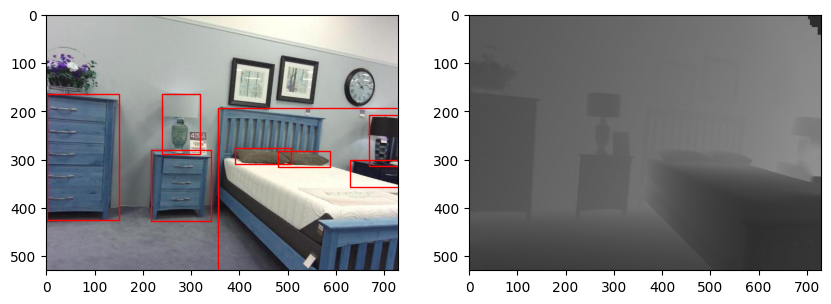

In [24]:
#Calls for any random image and Performs Preprocessing as mentioned
info = infos[10]
annos = info['annotations']
rgb = cv2.imread(str(ROOT/info['image']))
dpt = cv2.imread(str(ROOT/info['depth_bfx']))

plt.figure(figsize=(10,10))
ax = plt.subplot(121)
for anno in annos:
    print(anno)
    c = anno['classname']
    x0, y0, w, h = anno['bbox']
    rect = Rectangle(
        [x0, y0], w, h,
        facecolor='none',
        edgecolor='r'
    )
    ax.add_patch(rect)
ax.imshow(rgb)

plt.subplot(122)
plt.imshow(dpt)
plt.show()

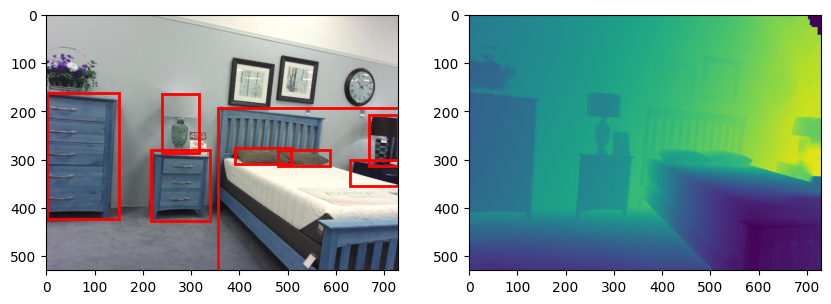

In [26]:
#Updated code to visualize RGB color depth Map
import pathlib
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

ROOT = pathlib.Path('C:\\Users\\Archana Jayaraman\\Downloads\\archive (4)\\MYSUN')

with open(ROOT/'info.json') as f:
    infos = json.load(f)

info = infos[10]
annos = info['annotations']
rgb = cv2.imread(str(ROOT/info['image']))
depth_map = depth_map = cv2.imread(str(ROOT/info['depth_bfx']), cv2.IMREAD_UNCHANGED).astype(np.float32) / 1000.0

# Convert depth to meters (adjust the scaling factor as needed)
    
plt.figure(figsize=(10, 10))
ax = plt.subplot(121)

# Initialize an empty list to store the combined point cloud
combined_point_cloud = []

for anno in annos:
    c = anno['classname']
    x0, y0, w, h = map(int, anno['bbox'])  # Convert bounding box values to integers

    # Extract the depth values within the bounding box
    depth_values = depth_map[y0:y0 + h, x0:x0 + w]

    # Define camera intrinsic parameters (adjust these according to your setup)
    fx = 525.0
    fy = 525.0
    cx = rgb.shape[1] / 2.0
    cy = rgb.shape[0] / 2.0

    # Create 3D point cloud for the object
    v, u = np.indices(depth_values.shape)
    z = depth_values
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy

    # Stack the 3D points and add them to the combined point cloud
    object_point_cloud = np.column_stack((x.flatten(), y.flatten(), z.flatten()))
    combined_point_cloud.extend(object_point_cloud)

    # Add a red rectangle to the RGB image to visualize the bounding box
    rect = Rectangle(
        (x0, y0), w, h,
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

ax.imshow(rgb)

# Visualization of the depth map
plt.subplot(122)
plt.imshow(depth_map)
plt.show()

# 'combined_point_cloud' now contains the combined 3D point cloud for all objects in the annotations
# You can further process or visualize this point cloud as needed


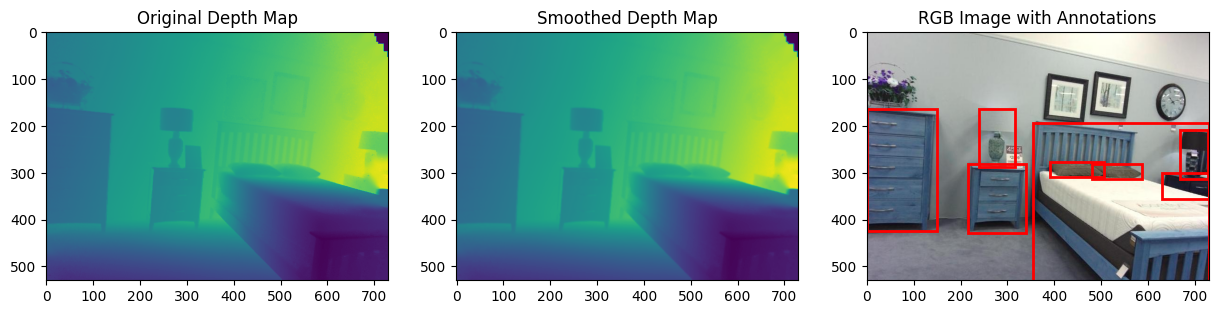

In [28]:
# This code is with outliers removed and Guassian smoothing applied
import pathlib
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import LocalOutlierFactor

ROOT = pathlib.Path('C:\\Users\\Archana Jayaraman\\Downloads\\archive (4)\\MYSUN')  # Adjust to your dataset path

with open(ROOT / 'info.json') as f:
    infos = json.load(f)

info = infos[10]
annos = info['annotations']
rgb = cv2.imread(str(ROOT / info['image']))
depth_map = cv2.imread(str(ROOT / info['depth_bfx']), cv2.IMREAD_UNCHANGED).astype(np.float32) / 1000.0

# Apply Gaussian smoothing to the depth map
depth_map_smoothed = gaussian_filter(depth_map, sigma=1)

plt.figure(figsize=(15, 5))

# Original Depth Map
plt.subplot(131)
plt.imshow(depth_map)
plt.title("Original Depth Map")

# Smoothed Depth Map
plt.subplot(132)
plt.imshow(depth_map_smoothed)
plt.title("Smoothed Depth Map")

ax = plt.subplot(133)

combined_point_cloud = []

for anno in annos:
    c = anno['classname']
    x0, y0, w, h = map(int, anno['bbox'])

    depth_values = depth_map_smoothed[y0:y0 + h, x0:x0 + w]

    # Apply Local Outlier Factor to detect and remove outliers in the depth values
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    v, u = np.indices(depth_values.shape)
    z = depth_values.flatten()
    valid_mask = lof.fit_predict(np.column_stack((u.flatten(), v.flatten(), z))) > 0

    # Use only the inlier points to create the point cloud
    v, u, z = v.flatten()[valid_mask], u.flatten()[valid_mask], z[valid_mask]

    fx = 525.0  # adjust these according to your setup
    fy = 525.0  # adjust these according to your setup
    cx = rgb.shape[1] / 2.0
    cy = rgb.shape[0] / 2.0

    x = (u - cx) * z / fx
    y = (v - cy) * z / fy

    object_point_cloud = np.column_stack((x, y, z))
    combined_point_cloud.extend(object_point_cloud)

    rect = Rectangle((x0, y0), w, h, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.imshow(rgb)
plt.title("RGB Image with Annotations")
plt.show()

# Now 'combined_point_cloud' contains the combined 3D point cloud for all objects
# with outliers removed and smoothing applied


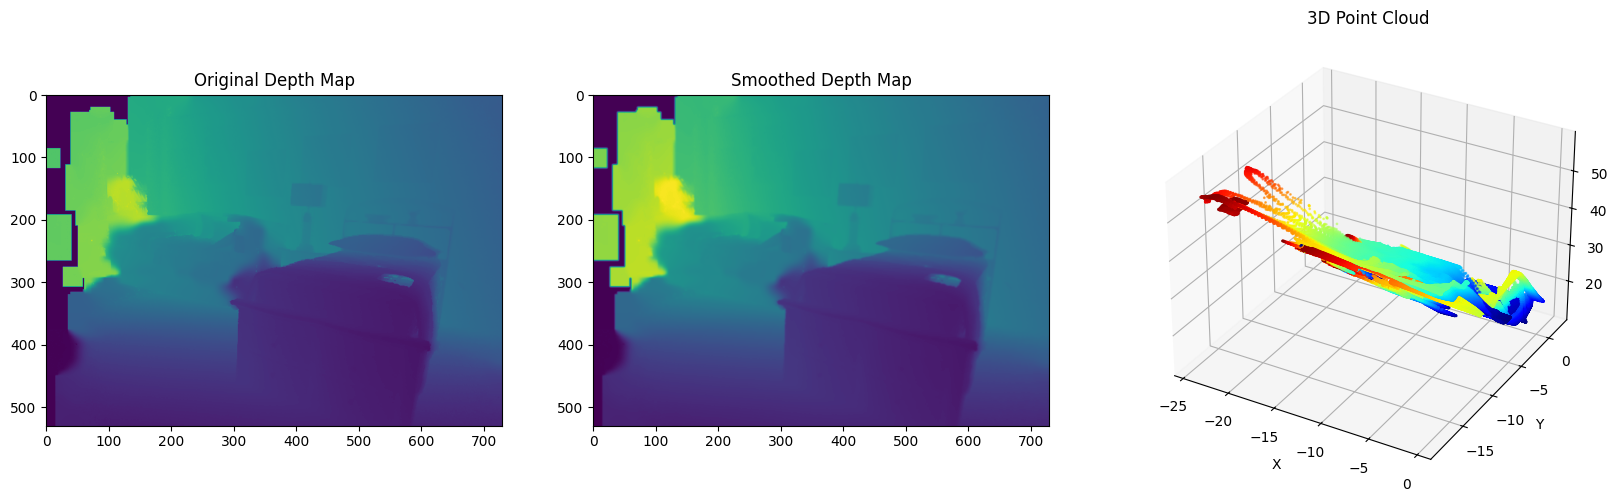

In [33]:
#Depicting different Angle of the 2D image
import pathlib
import json
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.neighbors import LocalOutlierFactor

ROOT = pathlib.Path('C:\\Users\\Archana Jayaraman\\Downloads\\archive (4)\\MYSUN')  # Adjust to your dataset path

with open(ROOT / 'info.json') as f:
    infos = json.load(f)

info = infos[19]
annos = info['annotations']
rgb = cv2.imread(str(ROOT / info['image']))
depth_map = cv2.imread(str(ROOT / info['depth_bfx']), cv2.IMREAD_UNCHANGED).astype(np.float32) / 1000.0

# Apply Gaussian smoothing to the depth map
depth_map_smoothed = gaussian_filter(depth_map, sigma=1)

# Initialize the plot
fig = plt.figure(figsize=(20, 10))

# Plot the original and smoothed depth maps
ax1 = fig.add_subplot(131)
ax1.imshow(depth_map)
ax1.set_title("Original Depth Map")

ax2 = fig.add_subplot(132)
ax2.imshow(depth_map_smoothed)
ax2.set_title("Smoothed Depth Map")

# Setup the 3D plot for the point cloud
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title("3D Point Cloud")

combined_point_cloud = []

for anno in annos:
    c = anno['classname']
    x0, y0, w, h = map(int, anno['bbox'])

    depth_values = depth_map_smoothed[y0:y0 + h, x0:x0 + w]

    # Apply Local Outlier Factor to detect and remove outliers in the depth values
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    v, u = np.indices(depth_values.shape)
    z = depth_values.flatten()
    valid_mask = lof.fit_predict(np.column_stack((u.flatten(), v.flatten(), z))) > 0

    # Use only the inlier points to create the point cloud
    v, u, z = v.flatten()[valid_mask], u.flatten()[valid_mask], z[valid_mask]

    fx = 800.0  # adjust these according to your setup
    fy = 800.0  # adjust these according to your setup
    cx = rgb.shape[1] / 2.0
    cy = rgb.shape[0] / 2.0

    x = (u - cx) * z / fx
    y = (v - cy) * z / fy

    object_point_cloud = np.column_stack((x, y, z))
    combined_point_cloud.extend(object_point_cloud)

    # Color by depth
    colors = plt.cm.jet((z - min(z)) / (max(z) - min(z)))

    # Add points to the 3D plot
    ax3.scatter(x, y, z, color=colors, s=1)

# Set axes labels
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

# Show the plot
plt.show()

# 'combined_point_cloud' now contains the combined 3D point cloud for all objects


In [ ]:
#Move to the next code. This is just a try
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)
# Load an image to condition on.
img = Image.open('example_data/cube_stack.jpg')

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[img]))):
    samples = x
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:27<00:00, 34.5MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

0it [00:00, ?it/s]

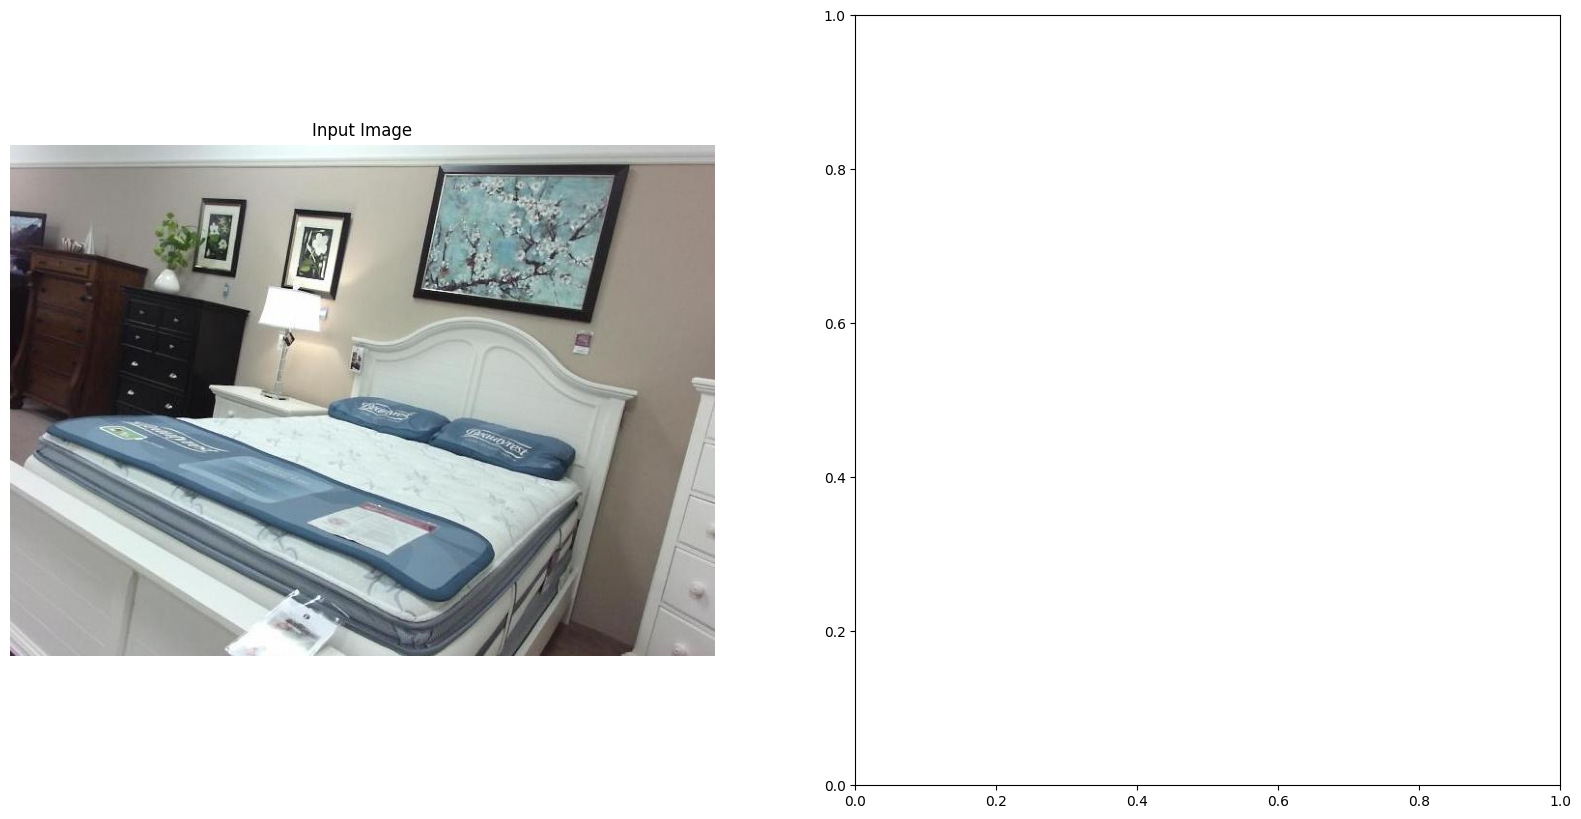

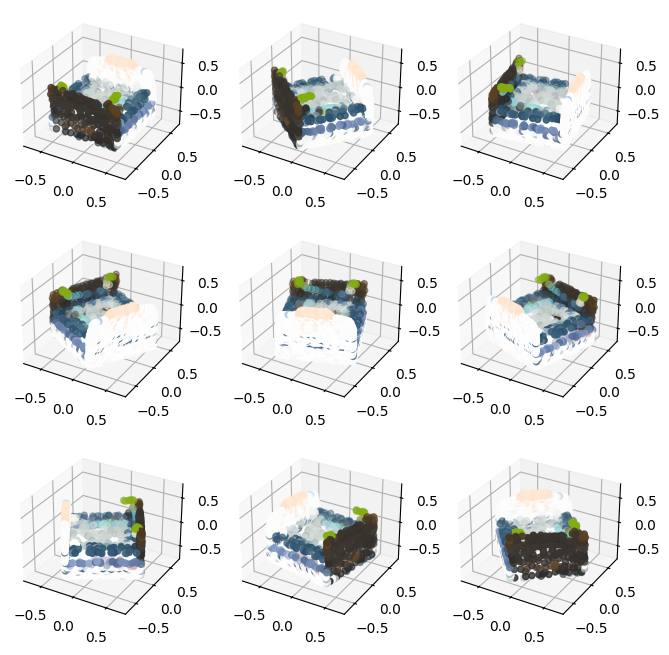

In [34]:
#Final  point cloud image Depicting Different Angles. But One Depth Map w got as NULL. 
# Couldnt able to Re-Run the script is as Script is Running for 856M one single time as it will process one image per batch
import pathlib
import json
from PIL import Image
import torch
from tqdm.auto import tqdm
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
import matplotlib.pyplot as plt

# Set the root path to the dataset
ROOT = pathlib.Path('C:\\Users\\Archana Jayaraman\\Downloads\\archive (4)\\MYSUN')  # Adjust to your dataset path

# Load the information from info.json
with open(ROOT / 'info.json') as f:
    infos = json.load(f)

# Select one entry from the infos
info = infos[14]  # Adjust the index to the image you want to use

# Set up device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and prepare the models
print('creating base model...')
base_name = 'base40M'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

# Create a sampler
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

# Prepare the plot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Load the input image from the dataset
input_image_path = ROOT / info['image']
input_image = Image.open(input_image_path)
axs[0].imshow(input_image)
axs[0].set_title('Input Image')
axs[0].axis('off')

# Generate the point cloud
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[input_image]))):
    samples = x
pc = sampler.output_to_point_clouds(samples)[0]

# Plot the point cloud
axs[1] = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75), (0.75, 0.75, 0.75)))
-+=
plt.show()


Number of classes (subdirectories): 8
Visualizing PLY file: fed8994632223d52afe1d4530f4c6e24__7__.ply


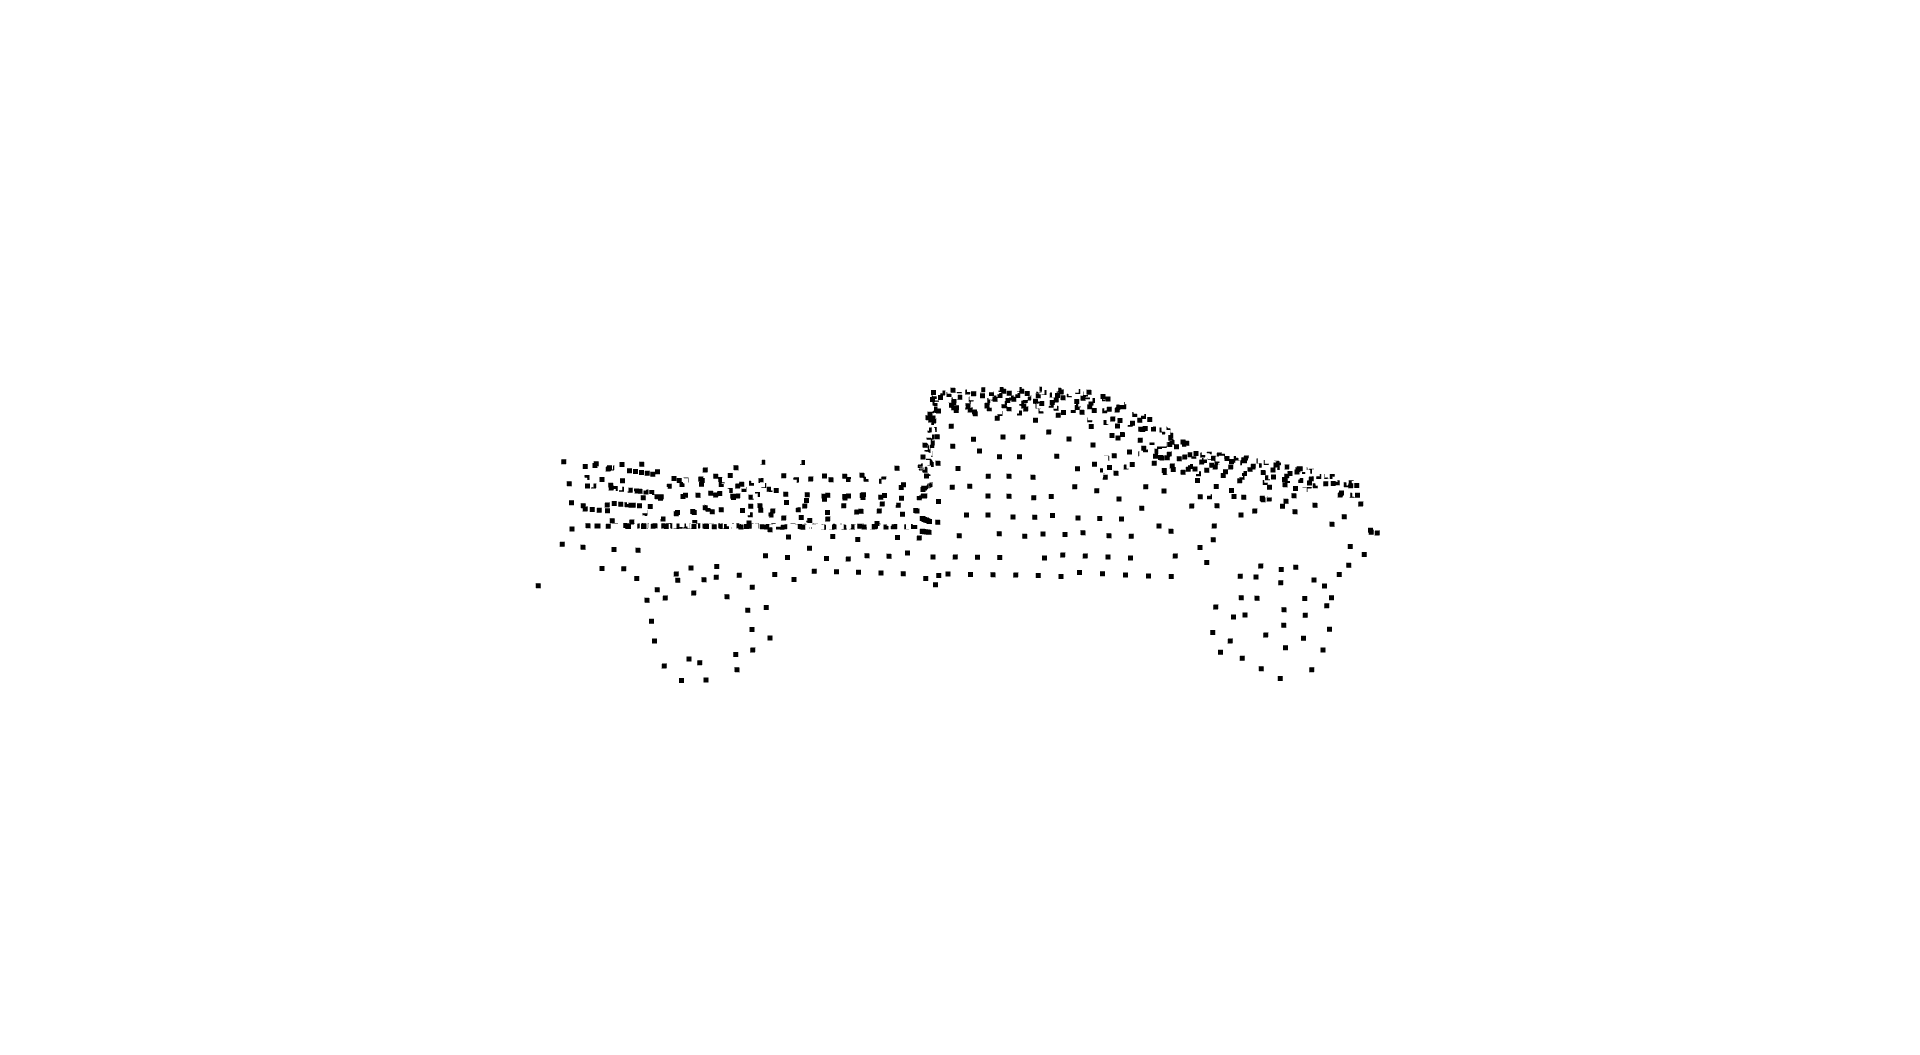

In [44]:
import open3d as o3d
import os
import random
from IPython.display import Image, display

def visualize_and_save_point_cloud(file_path, save_path):
    pcd = o3d.io.read_point_cloud(file_path)
    if pcd.is_empty():
        print(f"Failed to load point cloud from {file_path}")
    else:
        # Visualize and save the render as an image
        vis = o3d.visualization.Visualizer()
        vis.create_window(visible=False)  # Create a window that is not displayed
        vis.add_geometry(pcd)
        vis.update_geometry(pcd)
        vis.poll_events()
        vis.update_renderer()
        vis.capture_screen_image(save_path)
        vis.destroy_window()

# Root directory of the dataset
root_dir = "C:\\Users\\Archana Jayaraman\\Final_Project\\point-e\\3depn_generated\\shapenet_dim32_sdf_pc"

# List all subdirectories
subdirectories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
print("Number of classes (subdirectories):", len(subdirectories))

# Randomly pick a class
random_class = random.choice(subdirectories)
class_dir = os.path.join(root_dir, random_class)

# List all .ply files in the class directory
ply_files = [f for f in os.listdir(class_dir) if f.endswith('.ply')]

# Randomly pick a .ply file
if ply_files:
    random_ply_file = random.choice(ply_files)
    ply_file_path = os.path.join(class_dir, random_ply_file)
    print("Visualizing PLY file:", random_ply_file)

    # Save visualization as an image
    image_path = os.path.join(class_dir, "temp_visualization.png")
    visualize_and_save_point_cloud(ply_file_path, image_path)
    
    # Display the saved image
    display(Image(filename=image_path))
else:
    print("No PLY files found in the selected class directory.")
